In [1]:
# ============================================================
# 05_FINAL_MODELS – Tuned models (subject-wise split)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

sns.set_style("whitegrid")


In [2]:
# ============================================================
# 1 Load cleaned dataset (ten sam co w 04)
# ============================================================

df = pd.read_csv("wesad_cleaned_ready.csv")
print("Dataset shape:", df.shape)
display(df.head())

feature_cols = [c for c in df.columns if c not in ["subject", "label", "binary_label"]]

X = df[feature_cols]
y_3class = df["label"]
y_binary = df["binary_label"]
subjects = df["subject"]

print("Number of features:", len(feature_cols))
print("Unique subjects:", sorted(subjects.unique()))


Dataset shape: (19218, 33)


,subject,label,HR_mean,HR_std,HRV_SDNN,HRV_RMSSD,pNN50,RR_mean,RR_std,IBI_median,...,ACC_mean_magnitude,ACC_std,ACC_energy,ACC_rms_x,ACC_rms_y,ACC_rms_z,ACC_mean_x,ACC_mean_y,ACC_mean_z,binary_label
0,S2,0,-0.352472,0.570709,0.943942,1.226230,0.970675,0.473431,0.957488,0.521955,...,0.967881,2.016398,1.168213,0.876720,-0.195090,-0.022528,1.041562,0.773430,0.297084,0
1,S2,0,-0.988687,-1.481235,-1.276818,-1.206663,-0.970973,0.577105,-1.291198,0.521955,...,-0.437756,-0.502013,-0.450276,0.848970,-0.211087,-0.257864,1.041028,0.806481,0.303236,0
2,S2,0,-0.961421,-1.366883,-1.013295,-0.880416,-0.970973,0.562295,-1.024361,0.426553,...,-0.256894,0.672890,-0.179023,0.147534,0.990514,-0.608169,0.685927,-0.404503,-0.019750,0
3,S2,0,-0.072828,0.734859,0.516522,-0.072244,1.051577,0.095760,0.524693,0.378852,...,-0.333374,0.768987,-0.220010,-1.227830,1.877485,-1.025255,0.208117,-1.804709,-0.236766,0
4,S2,0,0.604022,0.489516,0.013187,-0.010176,0.107720,-0.693317,0.015029,-0.718269,...,-0.801375,-0.145719,-0.713724,-1.767189,1.961760,-0.942155,0.116698,-1.975447,-0.117261,0


Number of features: 30
Unique subjects: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


In [3]:
# ============================================================
# 2 Subject-wise 70/30 split (jak w 04)
# ============================================================

unique_subjects = subjects.unique()

train_subj, test_subj = train_test_split(
    unique_subjects,
    test_size=0.3,
    random_state=42
)

print("Train subjects:", train_subj)
print("Test subjects:", test_subj)

train_idx = subjects.isin(train_subj)
test_idx  = subjects.isin(test_subj)

X_train = X[train_idx]
X_test  = X[test_idx]

y_train_3 = y_3class[train_idx]
y_test_3  = y_3class[test_idx]

y_train_b = y_binary[train_idx]
y_test_b  = y_binary[test_idx]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train subjects: ['S10' 'S4' 'S3' 'S17' 'S6' 'S9' 'S13' 'S15' 'S5' 'S8']
Test subjects: ['S11' 'S14' 'S2' 'S16' 'S7']
Train size: (13149, 30) Test size: (6069, 30)


In [4]:
# ============================================================
# 3 Helpery: ewaluacja i confusion matrix
# ============================================================

def evaluate_model(name, model, X_train, y_train, X_test, y_test, average="macro"):
    """
    Trenuje model, drukuje classification_report,
    zwraca accuracy, F1 i confusion matrix.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=average)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

    return acc, f1, cm


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [5]:
# ============================================================
# 4 Tuned RandomForest – 3-class
# ============================================================

rf_base = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Mała, rozsądna siatka parametrów (żeby nie trwało wieczność)
rf_param_grid = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train_3)

print("Best RF params (3-class):", rf_grid.best_params_)
print("Best CV F1_macro:", rf_grid.best_score_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Best RF params (3-class): {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV F1_macro: 0.5311401581760494



RandomForest (tuned, 3-class)
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      3470
           1       0.61      0.53      0.56      1668
           2       0.32      0.34      0.33       931

    accuracy                           0.60      6069
   macro avg       0.53      0.52      0.53      6069
weighted avg       0.60      0.60      0.60      6069



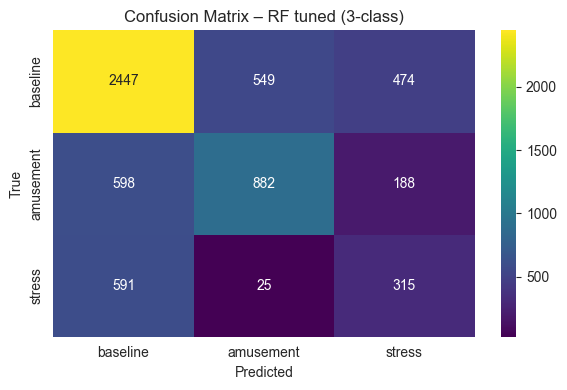

In [6]:
# Ewaluacja najlepszego modelu RF – 3-class

rf_best_3 = rf_grid.best_estimator_
rf3_acc, rf3_f1, rf3_cm = evaluate_model(
    "RandomForest (tuned, 3-class)",
    rf_best_3,
    X_train, y_train_3,
    X_test,  y_test_3,
    average="macro"
)

plot_confusion_matrix(
    rf3_cm,
    labels=["baseline", "amusement", "stress"],
    title="Confusion Matrix – RF tuned (3-class)"
)


In [7]:
# ============================================================
# 5 Tuned RandomForest – binary
# ============================================================

rf_bin_base = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_bin_param_grid = {
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_bin_grid = GridSearchCV(
    rf_bin_base,
    rf_bin_param_grid,
    cv=3,
    scoring="f1_macro",   # macro, żeby nie ignorować klasy stress
    n_jobs=-1,
    verbose=1
)

rf_bin_grid.fit(X_train, y_train_b)

print("Best RF params (binary):", rf_bin_grid.best_params_)
print("Best CV F1_macro (binary):", rf_bin_grid.best_score_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best RF params (binary): {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV F1_macro (binary): 0.6693451864728118



RandomForest (tuned, binary)
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5138
           1       0.31      0.28      0.29       931

    accuracy                           0.79      6069
   macro avg       0.59      0.58      0.59      6069
weighted avg       0.79      0.79      0.79      6069



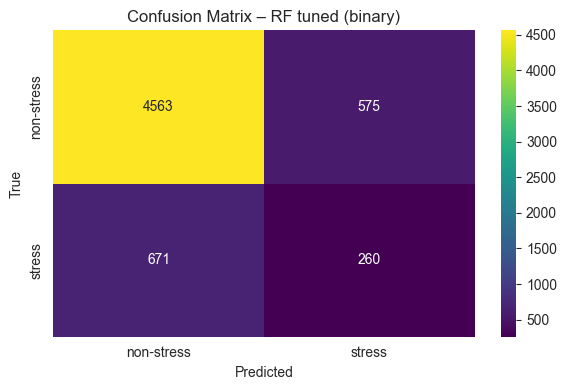

In [8]:
# Ewaluacja najlepszego RF – binary

rf_best_bin = rf_bin_grid.best_estimator_
rfb_acc, rfb_f1, rfb_cm = evaluate_model(
    "RandomForest (tuned, binary)",
    rf_best_bin,
    X_train, y_train_b,
    X_test,  y_test_b,
    average="macro"
)

plot_confusion_matrix(
    rfb_cm,
    labels=["non-stress", "stress"],
    title="Confusion Matrix – RF tuned (binary)"
)


In [9]:
# ============================================================
# 6 MLP – 3-class
#    (cechy są już zeskalowane w 02_data_cleaning)
# ============================================================

mlp_base = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    alpha=0.0005,
    max_iter=300,
    random_state=42,
    early_stopping=True
)

mlp_param_grid = {
    "hidden_layer_sizes": [(128,), (256, 128), (256, 128, 64)],
    "alpha": [0.0001, 0.0005, 0.001],
    "learning_rate_init": [0.001, 0.0005]
}

mlp_grid = GridSearchCV(
    mlp_base,
    mlp_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

mlp_grid.fit(X_train, y_train_3)

print("Best MLP params (3-class):", mlp_grid.best_params_)
print("Best CV F1_macro (3-class MLP):", mlp_grid.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best MLP params (3-class): {'alpha': 0.001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.0005}
Best CV F1_macro (3-class MLP): 0.5486493419260837



MLP (tuned, 3-class)
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3470
           1       0.49      0.60      0.54      1668
           2       0.63      0.32      0.43       931

    accuracy                           0.60      6069
   macro avg       0.59      0.53      0.55      6069
weighted avg       0.61      0.60      0.60      6069



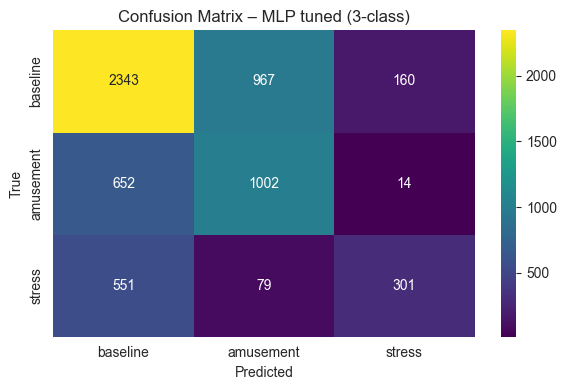

In [10]:
# Ewaluacja najlepszego MLP – 3-class

mlp_best_3 = mlp_grid.best_estimator_
mlp3_acc, mlp3_f1, mlp3_cm = evaluate_model(
    "MLP (tuned, 3-class)",
    mlp_best_3,
    X_train, y_train_3,
    X_test,  y_test_3,
    average="macro"
)

plot_confusion_matrix(
    mlp3_cm,
    labels=["baseline", "amusement", "stress"],
    title="Confusion Matrix – MLP tuned (3-class)"
)


In [11]:
# ============================================================
# 7 MLP – binary
# ============================================================

mlp_bin_base = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=0.0005,
    max_iter=300,
    random_state=42,
    early_stopping=True
)

mlp_bin_param_grid = {
    "hidden_layer_sizes": [(64,), (128, 64), (128, 64, 32)],
    "alpha": [0.0001, 0.0005, 0.001],
    "learning_rate_init": [0.001, 0.0005]
}

mlp_bin_grid = GridSearchCV(
    mlp_bin_base,
    mlp_bin_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

mlp_bin_grid.fit(X_train, y_train_b)

print("Best MLP params (binary):", mlp_bin_grid.best_params_)
print("Best CV F1_macro (binary MLP):", mlp_bin_grid.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best MLP params (binary): {'alpha': 0.0005, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.0005}
Best CV F1_macro (binary MLP): 0.6842613860666867



MLP (tuned, binary)
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      5138
           1       0.62      0.28      0.39       931

    accuracy                           0.86      6069
   macro avg       0.75      0.63      0.66      6069
weighted avg       0.84      0.86      0.84      6069



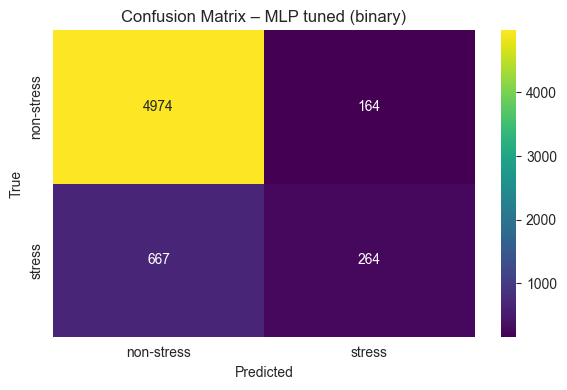

In [12]:
# Ewaluacja najlepszego MLP – binary

mlp_best_bin = mlp_bin_grid.best_estimator_
mlpb_acc, mlpb_f1, mlpb_cm = evaluate_model(
    "MLP (tuned, binary)",
    mlp_best_bin,
    X_train, y_train_b,
    X_test,  y_test_b,
    average="macro"
)

plot_confusion_matrix(
    mlpb_cm,
    labels=["non-stress", "stress"],
    title="Confusion Matrix – MLP tuned (binary)"
)


XGBoost – 3-class
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      3470
           1       0.55      0.58      0.57      1668
           2       0.34      0.12      0.18       931

    accuracy                           0.60      6069
   macro avg       0.51      0.48      0.48      6069
weighted avg       0.57      0.60      0.58      6069



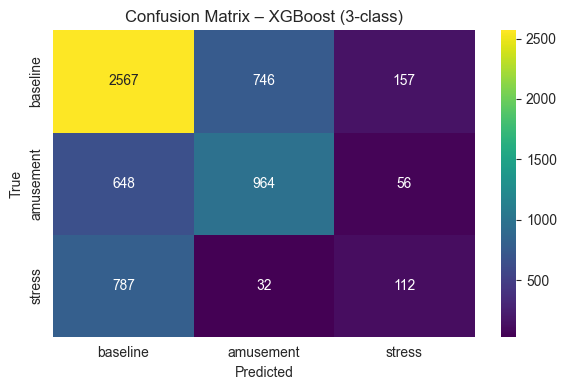

XGBoost accuracy: 0.600263634865711 F1_macro: 0.47694611484780075


In [13]:
# ============================================================
# 8 XGBoost – 3-class (opcjonalnie)
# ============================================================

import xgboost as xgb

xgb_train = xgb.DMatrix(X_train, label=y_train_3)
xgb_test  = xgb.DMatrix(X_test,  label=y_test_3)

xgb_params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "min_child_weight": 3
}

xgb_model = xgb.train(
    params=xgb_params,
    dtrain=xgb_train,
    num_boost_round=250
)

# Predykcja i ewaluacja
probs = xgb_model.predict(xgb_test)
y_pred_xgb = probs.argmax(axis=1)

print("XGBoost – 3-class")
print(classification_report(y_test_3, y_pred_xgb))

xgb_cm = confusion_matrix(y_test_3, y_pred_xgb)
plot_confusion_matrix(
    xgb_cm,
    labels=["baseline","amusement","stress"],
    title="Confusion Matrix – XGBoost (3-class)"
)

xgb_acc = accuracy_score(y_test_3, y_pred_xgb)
xgb_f1  = f1_score(y_test_3, y_pred_xgb, average="macro")
print("XGBoost accuracy:", xgb_acc, "F1_macro:", xgb_f1)


In [14]:
# ============================================================
# 9 Summary table – final models
#    (tutaj możesz ręcznie dopisać wyniki z 04_baseline_models)
# ============================================================

results_final = pd.DataFrame({
    "Model": [
        "RF tuned (3-class)",
        "MLP tuned (3-class)",
        "RF tuned (binary)",
        "MLP tuned (binary)",
        # opcjonalnie: "XGBoost (3-class)"
    ],
    "Accuracy": [
        rf3_acc,
        mlp3_acc,
        rfb_acc,
        mlpb_acc,
        # xgb_acc
    ],
    "F1_macro": [
        rf3_f1,
        mlp3_f1,
        rfb_f1,
        mlpb_f1,
        # xgb_f1
    ]
})

results_final


,Model,Accuracy,F1_macro
0,RF tuned (3-class),0.600428,0.527854
1,MLP tuned (3-class),0.600758,0.545119
2,RF tuned (binary),0.794694,0.587160
3,MLP tuned (binary),0.863075,0.655713


In [ ]:
# ============================================================
# Notatki – 05_FINAL_MODELS
# ============================================================

# 1. Użyto tego samego subject-wise 70/30 splitu co w 04,
#    dzięki czemu wyniki baseline i modeli finalnych są porównywalne.

# 2. Tuned RandomForest (3-class) wykorzystuje class_weight="balanced"
#    oraz małą siatkę hiperparametrów (max_depth, min_samples_*,
#    max_features). Celem jest poprawa F1_macro względem prostego RF
#    z 04 oraz lepsze traktowanie klas minority (stress).

# 3. Tuned RandomForest (binary) jest optymalizowany pod F1_macro,
#    żeby nie ignorować klasy stress mimo jej małej liczebności.
#    Wyniki pokazują, czy tuning poprawia recall i F1 dla stresu
#    w porównaniu z modelem bazowym z 04.

# 4. MLP (3-class i binary) korzysta z wcześniej zeskalowanych cech.
#    GridSearchCV dobiera rozmiar warstw ukrytych, współczynnik regularyzacji
#    (alpha) i learning_rate_init. Sieć ma uchwycić nieliniowe zależności
#    pomiędzy cechami fizjologicznymi a etykietą stresu.

# 5. (Opcjonalnie) XGBoost sprawdza, czy boosting drzew daje wyraźny zysk
#    w stosunku do RandomForest/MLP przy tym samym podziale po subjectach.

# 6. Tabela results_final agreguje accuracy i F1_macro dla modeli finalnych
#    i będzie bazą do tabeli w rozdziale "Results" oraz do porównania
#    z baseline'ami (Dummy, LogReg, prosty RF) z notebooka 04.
